# Chapter 5: Masked Relationships

**When Multiple Regression Reveals Hidden Effects**

## Goal

Understand **masked relationships** - when bivariate analysis shows weak effects, but multiple regression reveals strong effects.

**The opposite of spurious association:**
- Spurious: Strong bivariate → Weak multiple regression
- Masked: Weak bivariate → Strong multiple regression

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('default')
%matplotlib inline

np.random.seed(42)

print('✓ Imports loaded')

✓ Imports loaded


In [2]:
# Import quap
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))
from src.quap import quap, QuapResult

print('✓ Loaded quap')

✓ Loaded quap


---

## Step 1: Load and Explore Primate Milk Data

**Dataset**: Primate milk composition and brain size

**Variables:**
- **K**: Kilocalories per gram of milk (energy density)
- **N**: Neocortex percent (brain size relative to total brain)
- **M**: Log body mass (kg)

**Research question**: What predicts milk energy content?

In [3]:
# Load primate milk data
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/milk.csv"
milk_data = pd.read_csv(url, sep=";")

print(f"Dataset shape: {milk_data.shape}")
print(f"\nFirst few rows:")
milk_data.head()

Dataset shape: (29, 8)

First few rows:


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [4]:
# Check for missing values
print("Missing values:")
print(milk_data[['kcal.per.g', 'neocortex.perc', 'mass']].isnull().sum())

# Remove rows with missing neocortex data
milk_complete = milk_data.dropna(subset=['neocortex.perc']).copy()

print(f"\nComplete cases: {len(milk_complete)} out of {len(milk_data)}")

Missing values:
kcal.per.g         0
neocortex.perc    12
mass               0
dtype: int64

Complete cases: 17 out of 29


In [5]:
# Extract and standardize variables
K = milk_complete['kcal.per.g'].values
N = milk_complete['neocortex.perc'].values
M = np.log(milk_complete['mass'].values)

# Standardize
K_std = (K - K.mean()) / K.std()
N_std = (N - N.mean()) / N.std()
M_std = (M - M.mean()) / M.std()

print("Variables standardized:")
print(f"  K (kcal/g): mean={K_std.mean():.3f}, std={K_std.std():.3f}")
print(f"  N (neocortex %): mean={N_std.mean():.3f}, std={N_std.std():.3f}")
print(f"  M (log mass): mean={M_std.mean():.3f}, std={M_std.std():.3f}")
print(f"\nSample size: {len(K_std)}")

Variables standardized:
  K (kcal/g): mean=0.000, std=1.000
  N (neocortex %): mean=-0.000, std=1.000
  M (log mass): mean=-0.000, std=1.000

Sample size: 17


### Exploratory Data Analysis

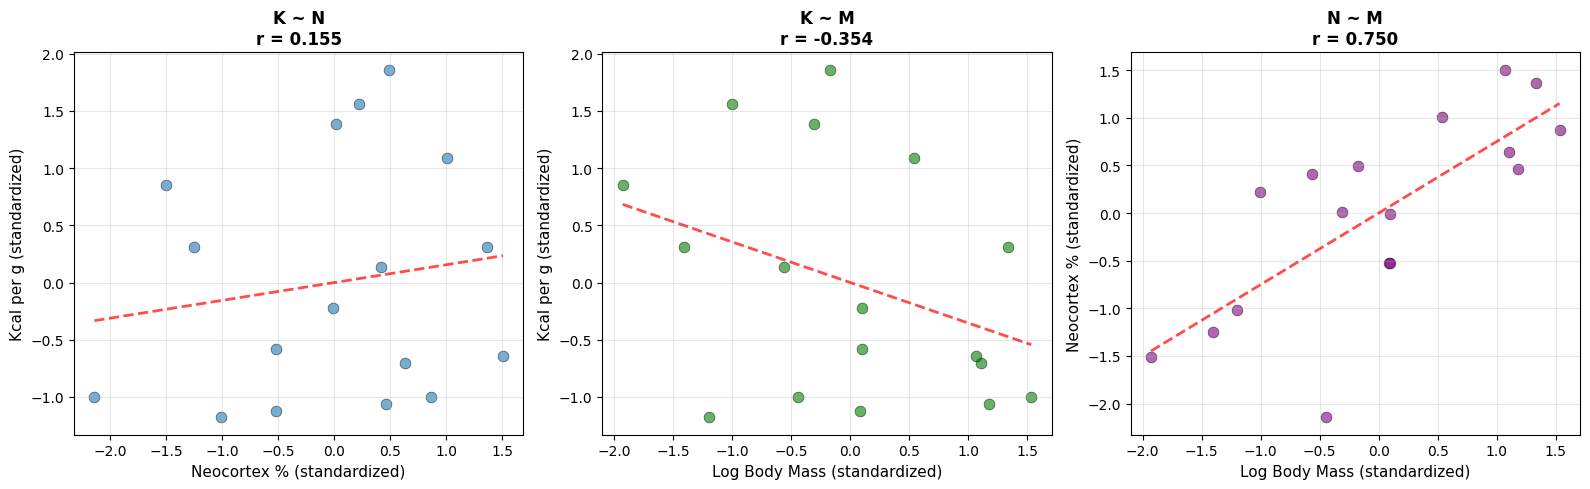

Key observations:
  K ~ N: weak positive correlation (r = 0.155)
  K ~ M: weak negative correlation (r = -0.354)
  N ~ M: strong positive correlation (r = 0.750)

⚠️ Both predictors show WEAK bivariate relationships with outcome!


In [6]:
# Visualize raw relationships
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: K vs N
ax = axes[0]
ax.scatter(N_std, K_std, s=60, alpha=0.6, edgecolor='black', linewidth=0.5)
# Add regression line
slope, intercept = np.polyfit(N_std, K_std, 1)
x_line = np.linspace(N_std.min(), N_std.max(), 100)
ax.plot(x_line, slope * x_line + intercept, 'r--', linewidth=2, alpha=0.7)
corr_KN = np.corrcoef(K_std, N_std)[0, 1]
ax.set_xlabel('Neocortex % (standardized)', fontsize=11)
ax.set_ylabel('Kcal per g (standardized)', fontsize=11)
ax.set_title(f'K ~ N\nr = {corr_KN:.3f}', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: K vs M
ax = axes[1]
ax.scatter(M_std, K_std, s=60, alpha=0.6, edgecolor='black', linewidth=0.5, color='green')
slope2, intercept2 = np.polyfit(M_std, K_std, 1)
x_line2 = np.linspace(M_std.min(), M_std.max(), 100)
ax.plot(x_line2, slope2 * x_line2 + intercept2, 'r--', linewidth=2, alpha=0.7)
corr_KM = np.corrcoef(K_std, M_std)[0, 1]
ax.set_xlabel('Log Body Mass (standardized)', fontsize=11)
ax.set_ylabel('Kcal per g (standardized)', fontsize=11)
ax.set_title(f'K ~ M\nr = {corr_KM:.3f}', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: N vs M (to see correlation)
ax = axes[2]
ax.scatter(M_std, N_std, s=60, alpha=0.6, edgecolor='black', linewidth=0.5, color='purple')
slope3, intercept3 = np.polyfit(M_std, N_std, 1)
x_line3 = np.linspace(M_std.min(), M_std.max(), 100)
ax.plot(x_line3, slope3 * x_line3 + intercept3, 'r--', linewidth=2, alpha=0.7)
corr_NM = np.corrcoef(N_std, M_std)[0, 1]
ax.set_xlabel('Log Body Mass (standardized)', fontsize=11)
ax.set_ylabel('Neocortex % (standardized)', fontsize=11)
ax.set_title(f'N ~ M\nr = {corr_NM:.3f}', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key observations:")
print(f"  K ~ N: weak positive correlation (r = {corr_KN:.3f})")
print(f"  K ~ M: weak negative correlation (r = {corr_KM:.3f})")
print(f"  N ~ M: strong positive correlation (r = {corr_NM:.3f})")
print("\n⚠️ Both predictors show WEAK bivariate relationships with outcome!")

---

## Step 2: Bivariate Regressions

Let's fit simple regressions to see the weak bivariate effects.

In [7]:
# Model 1: K ~ N
def neg_log_posterior_KN(params):
    alpha, beta_N, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_N * N_std
    log_lik = np.sum(stats.norm.logpdf(K_std, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) + 
                 stats.norm.logpdf(beta_N, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_KN = quap(neg_log_posterior_KN, [0, 0, np.log(1)], ['alpha', 'beta_N', 'log_sigma'])
m_KN.transform_param('log_sigma', 'sigma', np.exp)

print("Model 1: K ~ N")
m_KN.summary()

✓ Registered transformation: log_sigma -> sigma
Model 1: K ~ N
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0099 seconds
Log posterior at MAP: -24.49

          mean    std  89%_lower  89%_upper
alpha  -0.0003 0.1525    -0.2452     0.2415
beta_N  0.1277 0.2173    -0.2209     0.4737
sigma   1.0032 0.1708     0.7583     1.2942


,mean,std,89%_lower,89%_upper
alpha,-0.000303,0.152498,-0.245200,0.241543
beta_N,0.127658,0.217276,-0.220937,0.473708
sigma,1.003182,0.170832,0.758290,1.294226


In [8]:
# Model 2: K ~ M
def neg_log_posterior_KM(params):
    alpha, beta_M, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_M * M_std
    log_lik = np.sum(stats.norm.logpdf(K_std, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) + 
                 stats.norm.logpdf(beta_M, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_KM = quap(neg_log_posterior_KM, [0, 0, np.log(1)], ['alpha', 'beta_M', 'log_sigma'])
m_KM.transform_param('log_sigma', 'sigma', np.exp)

print("Model 2: K ~ M")
m_KM.summary()

✓ Registered transformation: log_sigma -> sigma
Model 2: K ~ M
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0106 seconds
Log posterior at MAP: -23.73

          mean    std  89%_lower  89%_upper
alpha  -0.0003 0.1492    -0.2399     0.2363
beta_M -0.2945 0.2084    -0.6273     0.0427
sigma   0.9519 0.1629     0.7132     1.2309


,mean,std,89%_lower,89%_upper
alpha,-0.000297,0.149202,-0.239900,0.236322
beta_M,-0.294501,0.208390,-0.627296,0.042749
sigma,0.951875,0.162915,0.713188,1.230872


In [9]:
# Compare bivariate effects
coef_KN = m_KN.coef()
coef_KM = m_KM.coef()

print("\nBivariate regression coefficients:")
print("="*70)
print(f"K ~ N:  β_N = {coef_KN['beta_N']:.3f}  (weak positive)")
print(f"K ~ M:  β_M = {coef_KM['beta_M']:.3f}  (weak negative)")
print("\n⚠️ Both effects are WEAK and uncertain!")
print("   The 89% intervals include zero or are close to it.")


Bivariate regression coefficients:
K ~ N:  β_N = 0.128  (weak positive)
K ~ M:  β_M = -0.295  (weak negative)

⚠️ Both effects are WEAK and uncertain!
   The 89% intervals include zero or are close to it.


---

## Step 3: Multiple Regression - Unmasking the Effects!

**Key question**: What happens when we include BOTH predictors?

In [10]:
# Model 3: K ~ N + M
def neg_log_posterior_KNM(params):
    alpha, beta_N, beta_M, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_N * N_std + beta_M * M_std
    log_lik = np.sum(stats.norm.logpdf(K_std, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) + 
                 stats.norm.logpdf(beta_N, 0, 0.5) +
                 stats.norm.logpdf(beta_M, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_KNM = quap(neg_log_posterior_KNM, [0, 0, 0, np.log(1)], 
             ['alpha', 'beta_N', 'beta_M', 'log_sigma'])
m_KNM.transform_param('log_sigma', 'sigma', np.exp)

print("Model 3: K ~ N + M")
m_KNM.summary()

✓ Registered transformation: log_sigma -> sigma
Model 3: K ~ N + M
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0176 seconds
Log posterior at MAP: -21.33

          mean    std  89%_lower  89%_upper
alpha   0.0010 0.1339    -0.2140     0.2125
beta_N  0.6241 0.2418     0.2422     1.0141
beta_M -0.7297 0.2398    -1.1094    -0.3497
sigma   0.7434 0.1375     0.5467     0.9787


,mean,std,89%_lower,89%_upper
alpha,0.000962,0.133876,-0.214010,0.212472
beta_N,0.624102,0.241751,0.242195,1.014144
beta_M,-0.729688,0.239822,-1.109401,-0.349738
sigma,0.743355,0.137464,0.546676,0.978687


In [11]:
# Compare all three models
coef_KNM = m_KNM.coef()

comparison = pd.DataFrame({
    'Bivariate K~N': [coef_KN['beta_N'], '—'],
    'Bivariate K~M': ['—', coef_KM['beta_M']],
    'Multiple K~N+M': [coef_KNM['beta_N'], coef_KNM['beta_M']]
}, index=['β_N (Neocortex)', 'β_M (Body Mass)'])

print("\nComparison: Bivariate vs Multiple Regression")
print("="*70)
print(comparison)
print("="*70)

print("\n🎯 MASKING REVEALED!")
print("   Bivariate: Both effects weak (~0.2-0.3)")
print(f"   Multiple:  β_N = {coef_KNM['beta_N']:.3f} (STRONGER positive!)")
print(f"   Multiple:  β_M = {coef_KNM['beta_M']:.3f} (STRONGER negative!)")
print("\n   The effects are REVEALED when both predictors are included!")


Comparison: Bivariate vs Multiple Regression
                Bivariate K~N Bivariate K~M  Multiple K~N+M
β_N (Neocortex)      0.127658             —        0.624102
β_M (Body Mass)             —     -0.294501       -0.729688

🎯 MASKING REVEALED!
   Bivariate: Both effects weak (~0.2-0.3)
   Multiple:  β_N = 0.624 (STRONGER positive!)
   Multiple:  β_M = -0.730 (STRONGER negative!)

   The effects are REVEALED when both predictors are included!


---

## Step 4: Why Does Masking Happen?

**The DAG:**
```
    M (Body Mass)
    /           \
   /             \
  ↓               ↓
  N           →   K
(Neocortex)   (Milk Energy)
```

**The mechanism:**
1. M → N: Larger animals have larger brains (positive correlation)
2. M → K: Larger animals have LESS energy-dense milk (negative effect)
3. N → K: Larger brains need MORE energy-dense milk (positive effect)

**The masking:**
- When you don't control for M, the negative M → K effect **masks** the positive N → K effect
- When you don't control for N, the positive N → K effect **masks** the negative M → K effect

Let's simulate this to understand it better!

In [12]:
# Simulate masked relationship
n_sim = 100
np.random.seed(123)

# 1. Generate body mass (independent)
M_sim = np.random.normal(0, 1, n_sim)

# 2. Generate neocortex from mass
#    N = 0.7*M + noise (positive relationship)
N_sim = 0.7 * M_sim + np.random.normal(0, 0.5, n_sim)

# 3. Generate milk energy from BOTH
#    K = 0.6*N - 0.6*M + noise
#    Positive effect of N, negative effect of M
K_sim = 0.6 * N_sim - 0.6 * M_sim + np.random.normal(0, 0.5, n_sim)

print("Simulated data according to DAG:")
print("  M → N (coefficient: +0.7)")
print("  N → K (coefficient: +0.6)")
print("  M → K (coefficient: -0.6)")
print(f"\nSample size: {n_sim}")

Simulated data according to DAG:
  M → N (coefficient: +0.7)
  N → K (coefficient: +0.6)
  M → K (coefficient: -0.6)

Sample size: 100


In [13]:
# Compute correlations
corr_KN_sim = np.corrcoef(K_sim, N_sim)[0, 1]
corr_KM_sim = np.corrcoef(K_sim, M_sim)[0, 1]
corr_NM_sim = np.corrcoef(N_sim, M_sim)[0, 1]

print("Correlations in simulated data:")
print("="*70)
print(f"  K ~ N: {corr_KN_sim:.3f}  (WEAK! But true effect is +0.6)")
print(f"  K ~ M: {corr_KM_sim:.3f}  (WEAK! But true effect is -0.6)")
print(f"  N ~ M: {corr_NM_sim:.3f}  (Strong positive)")
print("\n⚠️ Bivariate correlations UNDERESTIMATE the true causal effects!")
print("   This is MASKING in action.")

Correlations in simulated data:
  K ~ N: -0.069  (WEAK! But true effect is +0.6)
  K ~ M: -0.385  (WEAK! But true effect is -0.6)
  N ~ M: 0.849  (Strong positive)

⚠️ Bivariate correlations UNDERESTIMATE the true causal effects!
   This is MASKING in action.


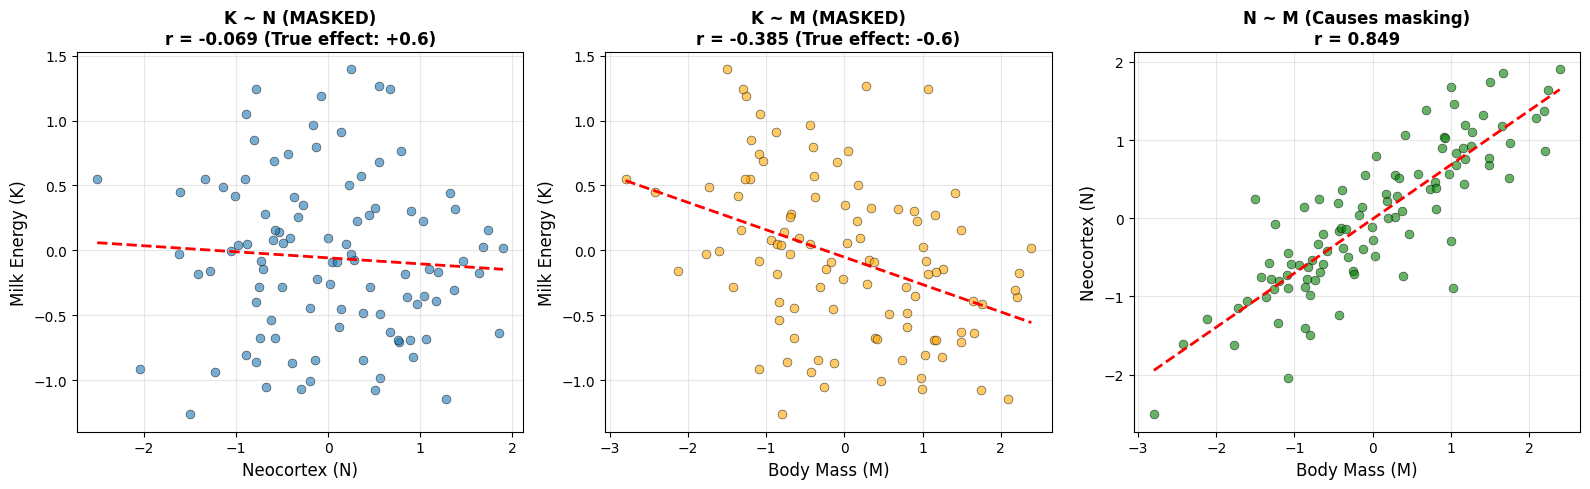


Key insight:
The strong positive correlation between N and M causes each
predictor's effect to be masked in bivariate analysis!


In [14]:
# Visualize the simulated masking
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: K ~ N (masked)
ax = axes[0]
ax.scatter(N_sim, K_sim, alpha=0.6, s=40, edgecolor='black', linewidth=0.5)
slope, intercept = np.polyfit(N_sim, K_sim, 1)
x_line = np.linspace(N_sim.min(), N_sim.max(), 100)
ax.plot(x_line, slope * x_line + intercept, 'r--', linewidth=2)
ax.set_xlabel('Neocortex (N)', fontsize=12)
ax.set_ylabel('Milk Energy (K)', fontsize=12)
ax.set_title(f'K ~ N (MASKED)\nr = {corr_KN_sim:.3f} (True effect: +0.6)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: K ~ M (masked)
ax = axes[1]
ax.scatter(M_sim, K_sim, alpha=0.6, s=40, edgecolor='black', linewidth=0.5, color='orange')
slope2, intercept2 = np.polyfit(M_sim, K_sim, 1)
x_line2 = np.linspace(M_sim.min(), M_sim.max(), 100)
ax.plot(x_line2, slope2 * x_line2 + intercept2, 'r--', linewidth=2)
ax.set_xlabel('Body Mass (M)', fontsize=12)
ax.set_ylabel('Milk Energy (K)', fontsize=12)
ax.set_title(f'K ~ M (MASKED)\nr = {corr_KM_sim:.3f} (True effect: -0.6)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: N ~ M (the confounding)
ax = axes[2]
ax.scatter(M_sim, N_sim, alpha=0.6, s=40, edgecolor='black', linewidth=0.5, color='green')
slope3, intercept3 = np.polyfit(M_sim, N_sim, 1)
x_line3 = np.linspace(M_sim.min(), M_sim.max(), 100)
ax.plot(x_line3, slope3 * x_line3 + intercept3, 'r--', linewidth=2)
ax.set_xlabel('Body Mass (M)', fontsize=12)
ax.set_ylabel('Neocortex (N)', fontsize=12)
ax.set_title(f'N ~ M (Causes masking)\nr = {corr_NM_sim:.3f}', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey insight:")
print("The strong positive correlation between N and M causes each")
print("predictor's effect to be masked in bivariate analysis!")

### Fit Regressions to Simulated Data

In [15]:
# Fit regressions to simulated data

# K ~ N (bivariate)
def neg_log_posterior_sim_KN(params):
    alpha, beta, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta * N_sim
    log_lik = np.sum(stats.norm.logpdf(K_sim, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 1) + 
                 stats.norm.logpdf(beta, 0, 1) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_sim_KN = quap(neg_log_posterior_sim_KN, [0, 0, np.log(1)], 
                ['alpha', 'beta', 'log_sigma'])
m_sim_KN.transform_param('log_sigma', 'sigma', np.exp)

# K ~ M (bivariate)
def neg_log_posterior_sim_KM(params):
    alpha, beta, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta * M_sim
    log_lik = np.sum(stats.norm.logpdf(K_sim, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 1) + 
                 stats.norm.logpdf(beta, 0, 1) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_sim_KM = quap(neg_log_posterior_sim_KM, [0, 0, np.log(1)], 
                ['alpha', 'beta', 'log_sigma'])
m_sim_KM.transform_param('log_sigma', 'sigma', np.exp)

# K ~ N + M (multiple)
def neg_log_posterior_sim_KNM(params):
    alpha, beta_N, beta_M, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_N * N_sim + beta_M * M_sim
    log_lik = np.sum(stats.norm.logpdf(K_sim, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 1) + 
                 stats.norm.logpdf(beta_N, 0, 1) +
                 stats.norm.logpdf(beta_M, 0, 1) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_sim_KNM = quap(neg_log_posterior_sim_KNM, [0, 0, 0, np.log(1)], 
                 ['alpha', 'beta_N', 'beta_M', 'log_sigma'])
m_sim_KNM.transform_param('log_sigma', 'sigma', np.exp)

print("✓ Fitted all models to simulated data")

✓ Registered transformation: log_sigma -> sigma
✓ Registered transformation: log_sigma -> sigma
✓ Registered transformation: log_sigma -> sigma
✓ Fitted all models to simulated data


In [16]:
# Compare estimates
coef_sim_KN = m_sim_KN.coef()
coef_sim_KM = m_sim_KM.coef()
coef_sim_KNM = m_sim_KNM.coef()

results = pd.DataFrame({
    'True Value': [0.6, -0.6],
    'K ~ N only': [coef_sim_KN['beta'], '—'],
    'K ~ M only': ['—', coef_sim_KM['beta']],
    'K ~ N + M': [coef_sim_KNM['beta_N'], coef_sim_KNM['beta_M']]
}, index=['β_N (Neocortex)', 'β_M (Body Mass)'])

print("\nRecovering True Effects from Masked Data:")
print("="*70)
print(results)
print("="*70)
print("\nObservations:")
print("• Bivariate regressions UNDERESTIMATE both effects (masking!)")
print("• Multiple regression K ~ N + M correctly recovers:")
print(f"    - β_N ≈ +0.6 (true effect)")
print(f"    - β_M ≈ -0.6 (true effect)")
print("\n✓ Multiple regression UNMASKS the hidden relationships!")


Recovering True Effects from Masked Data:
                 True Value K ~ N only K ~ M only  K ~ N + M
β_N (Neocortex)         0.6  -0.046102          —   0.611569
β_M (Body Mass)        -0.6          —  -0.210428  -0.632786

Observations:
• Bivariate regressions UNDERESTIMATE both effects (masking!)
• Multiple regression K ~ N + M correctly recovers:
    - β_N ≈ +0.6 (true effect)
    - β_M ≈ -0.6 (true effect)

✓ Multiple regression UNMASKS the hidden relationships!


---

## Step 5: Visualizing the Unmasking

Let's create plots showing how the effects are revealed.

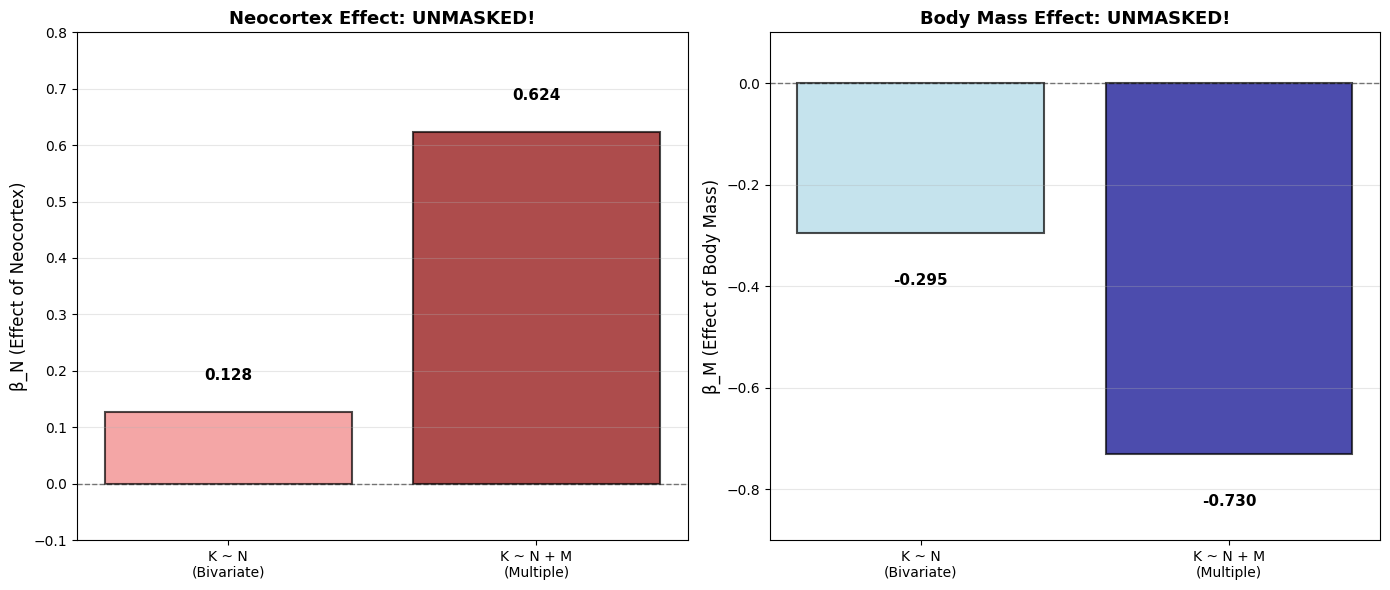


Key takeaway:
Multiple regression UNMASKS both effects, making them STRONGER!


In [17]:
# Coefficient plot comparing bivariate vs multiple
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Neocortex effect
ax = axes[0]
models = ['K ~ N\n(Bivariate)', 'K ~ N + M\n(Multiple)']
estimates = [coef_KN['beta_N'], coef_KNM['beta_N']]
colors = ['lightcoral', 'darkred']

bars = ax.bar(models, estimates, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_ylabel('β_N (Effect of Neocortex)', fontsize=12)
ax.set_title('Neocortex Effect: UNMASKED!', fontsize=13, fontweight='bold')
ax.set_ylim(-0.1, 0.8)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, est in zip(bars, estimates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{est:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Body mass effect
ax = axes[1]
estimates2 = [coef_KM['beta_M'], coef_KNM['beta_M']]
colors2 = ['lightblue', 'darkblue']

bars2 = ax.bar(models, estimates2, color=colors2, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_ylabel('β_M (Effect of Body Mass)', fontsize=12)
ax.set_title('Body Mass Effect: UNMASKED!', fontsize=13, fontweight='bold')
ax.set_ylim(-0.9, 0.1)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, est in zip(bars2, estimates2):
    height = bar.get_height()
    offset = -0.08 if height < 0 else 0.05
    va = 'top' if height < 0 else 'bottom'
    ax.text(bar.get_x() + bar.get_width()/2., height + offset,
            f'{est:.3f}', ha='center', va=va, fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey takeaway:")
print("Multiple regression UNMASKS both effects, making them STRONGER!")

---

## Summary

### What We Learned

**1. Masked Relationships**
- Bivariate analysis shows weak effects
- Multiple regression reveals strong effects
- The OPPOSITE of spurious associations

**2. The Mechanism**
- Two predictors are positively correlated (N and M)
- They have OPPOSITE effects on the outcome
  - N → K: positive effect (+)
  - M → K: negative effect (−)
- Each masks the other in bivariate analysis

**3. Why Multiple Regression Unmasks**
- Controlling for M reveals the true N → K effect
- Controlling for N reveals the true M → K effect
- Both effects become STRONGER and clearer

**4. The DAG Matters**
```
Spurious:      Masked:
   A              M
  / \            / \
 M   D          N   K
 
Common cause   Opposite effects
→ Inflate      → Cancel out
```

**5. Practical Lesson**
- Don't trust bivariate analysis alone!
- Weak correlations ≠ no causal effect
- Need theory (DAG) to guide modeling
- Multiple regression can REVEAL hidden effects

---

**End of Masked Relationships**